In [17]:
import os, sys
import copy
import socket
import torch
import pickle
from torch import optim
from torch.utils.tensorboard import SummaryWriter

#!pip install networkx matplotlib
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "../")))
from libs.topology_manager import *
from libs import fl, nn, data, log

In [18]:
# Save Logs To File (info | debug | warning | error | critical) [optional]
log.init("info")
#log.init("info", "federated.log")
#log.init("debug", "flkafka.log")

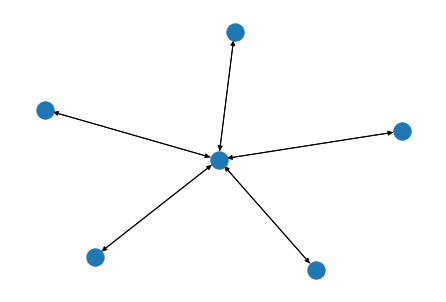

In [19]:
adj_mat = np.array([[0,1,1,1,1,1],
             [1,0,0,0,0,0],
             [1,0,0,0,0,0],
             [1,0,0,0,0,0],
             [1,0,0,0,0,0], 
             [1,0,0,0,0,0]])

node_type = {'aggregator': [0,1], 'trainer': [2,3], 'broadcaster': [4,5]}

di_graph = nx.DiGraph(adj_mat)
nx.draw(di_graph)

In [20]:
class FedArgs():
    def __init__(self):
        self.num_clients = len(adj_mat)
        self.epochs = 5
        self.local_rounds = 1
        self.client_batch_size = 32
        self.test_batch_size = 128
        self.learning_rate = 1e-4
        self.weight_decay = 1e-5
        self.cuda = False
        self.seed = 1
        self.topic = 'pyflx'
        self.tb = SummaryWriter('../out/runs/centralized', comment="Mnist Centralized Federated training")

fedargs = FedArgs()

In [21]:
use_cuda = fedargs.cuda and torch.cuda.is_available()
torch.manual_seed(fedargs.seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

In [22]:
host = socket.gethostname()
clients = [host + "(" + str(client + 1) + ")" for client in range(fedargs.num_clients)]
ctp = CentralizedTopology(adj_mat, clients, node_type)

In [23]:
# Load MNIST Data to clients
train_data, test_data = data.load_mnist_dataset()
clients_data = data.split_data(train_data, clients)
client_loaders, test_loader = data.load_client_data(clients_data, fedargs.client_batch_size, test_data, fedargs.test_batch_size, **kwargs)

# Load preliminary models
# if want to do random initialization, replace copy.deepcopy(global_model) with nn.ModelMNIST() and vice versa
global_model = nn.ModelMNIST().to(device)
clients_info = {
        client: { "model": nn.ModelMNIST().to(device), "loss": {}, "data_loader": client_loaders[client]}
        for client in clients
    }

In [ ]:
# Federated Training
for _epoch in range(fedargs.epochs):

    epoch = _epoch + 1
    log.info("Federated Training Epoch {} of {}".format(epoch, fedargs.epochs))
    
    # Average
    for client in clients:
        # @todo wont'work, untill topology manager gets updated
        rcvd_models = ctp.get_rcvd_models(client)
        log.info("Client {} received {} model updates".format(client, len(rcvd_models)))
        if len(rcvd_models) != 0:
            clients_info[client]['model'] = fl.federated_avg(rcvd_models)
            
    # Erase flush models
    ctp.flush_models()
    
    # Train
    for client in clients:
        clients_info[client]['model'], clients_info[client]['loss'] = fl.client_update(clients_info[client]['model'],
                                                                                clients_info[client]['data_loader'],     
                                                                                fedargs.learning_rate,
                                                                                fedargs.weight_decay,
                                                                                fedargs.local_rounds,
                                                                                device)
        # Broadcast
        # @todo wont'work, untill topology manager gets updated
        ctp.broadcast(client, client_models[str_client])

        for local_epoch, loss in enumerate(list(clients_info[client]['loss'].values())):
            fedargs.tb.add_scalars("Training Loss/" + client, 
                                   {str(epoch): loss}, 
                                   str(local_epoch + 1))

        log.jsondebug(clients_info[client]['loss'],
                     "Epoch {} of {} : Federated Training loss, Client {}".format(epoch, 
                                                                          fedargs.epochs, 
                                                                          client))
        log.modeldebug(clients_info[client]['model'],
                       "Epoch {} of {} : Client {} Update".format(epoch, 
                                                                  fedargs.epochs, 
                                                                  client))

    # Test Output for every node
    for client in clients:
        test_output = fl.eval(clients_info[client]['model'], test_loader, device)

        fedargs.tb.add_scalar("Test Loss/" + client, 
                              test_output["accuracy"], 
                              epoch)

        log.jsoninfo(test_output, 
                     "Test Outut after Epoch {} of {} for Client {}".format(epoch,
                                                                            fedargs.epochs,
                                                                            client))

2021-07-27 11:37:20,979 - <ipython-input-26-21a35de58427>::<module>(l:5) : Federated Training Epoch 1 of 5
2021-07-27 11:37:23,016 - <ipython-input-26-21a35de58427>::<module>(l:12) : Client bladecluster.iitp.org(1) received 0 model updates
2021-07-27 11:37:25,121 - <ipython-input-26-21a35de58427>::<module>(l:12) : Client bladecluster.iitp.org(2) received 0 model updates
2021-07-27 11:37:27,222 - <ipython-input-26-21a35de58427>::<module>(l:12) : Client bladecluster.iitp.org(3) received 0 model updates
2021-07-27 11:37:29,323 - <ipython-input-26-21a35de58427>::<module>(l:12) : Client bladecluster.iitp.org(4) received 0 model updates
2021-07-27 11:37:31,423 - <ipython-input-26-21a35de58427>::<module>(l:12) : Client bladecluster.iitp.org(5) received 0 model updates
2021-07-27 11:37:33,530 - <ipython-input-26-21a35de58427>::<module>(l:12) : Client bladecluster.iitp.org(6) received 0 model updates
2021-07-27 11:37:54,010 - /home/harsh_1921cs01/hub/X-PyFLX/libs/protobuf_producer.py::produce(l